<a href="https://colab.research.google.com/github/NamelessOgya/simple-chat-info-agent/blob/main/LangChain_%E3%82%A2%E3%83%8B%E3%83%A1%E8%81%9E%E3%81%8D%E5%87%BA%E3%81%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain
!pip install openai
!pip install langchain-openai
!pip install langgraph
!pip install firecrawl-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.3 MB/s eta 0:00:00


In [258]:
# アニメのジャンル
menu = {"ジャンル":
  [
    "SF/ファンタジー"
    ,"ロボット・メカ"
    ,"アクション・バトル"
    ,"コメディ・ギャグ"
    ,"恋愛・ラブコメ"
    ,"日常・ほのぼの"
    ,"スポーツ・競技"
    ,"ホラー・サスペンス・推理"
    ,"歴史・戦記"
    ,"戦争・ミリタリー"
    ,"ドラマ・青春"
    ,"キッズ・ファミリー"
    ,"ショート"
    ,"2.5次元舞台"
    ,"ライブ・ラジオ"
  ]
}

In [259]:
TEST = True

In [260]:
import os
from google.colab import userdata

#TODO: APIキーをsecretに登録してください。
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["GOOGLE_CSE_ID"] = userdata.get("GOOGLE_CSE_ID")
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["FIRE_CRAWL"] = userdata.get("FIRE_CRAWL")

In [261]:
MAX_REPLY_CNT = 4

# Lang GraphによるマルチエージェントAI作成  
LangGraphを用いてマルチエージェントを実装します。  
- Agent  
- AI user
  - 特定の役割に沿ってよしなに返答するエージェント


In [169]:
# from langchain.agents import initialize_agent, load_tools
from langchain_openai import ChatOpenAI


In [176]:
llm = ChatOpenAI(model = "gpt-4o-mini", api_key=os.environ["OPENAI_API_KEY"])

In [264]:
from langchain import LLMChain
from langchain.prompts import PromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

from typing import Annotated, Literal, List, Dict, Tuple
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph
from IPython.display import Image, display

import random


In [265]:
def get_output_with_schema(name, description, template, input_variables, input_values):
    """
      プロンプトに対する応答を特定のjson formatで受け取る。
    """

    # ここでスキーマを定義。
    response_schemas = [
        ResponseSchema(
            name=name,
            description=description
        )
    ]

    # スキーマを元に、「出力はJSON形式でお願いします」的なプロンプトを考えてくれる。
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    format_instructions = output_parser.get_format_instructions()

    prompt = PromptTemplate(
        template=template,
        input_variables=input_variables,
        # フォーマット指示をプロンプトへ差し込む
        partial_variables={"format_instructions": format_instructions} #かならず元promptに{format_instructions}を入れること！
    )

    chain = LLMChain(
        llm=llm,
        prompt=prompt
    )

    # requirement = "チョコレートが好きなアイドル"

    dic = {}
    for name, val in zip(input_variables, input_values):
      dic[name] = val

    raw_output = chain.run(dic)

    # 事前定義したスキーマを元に、json⇒辞書の変換を勝手にやってくれる。
    parsed_output = output_parser.parse(raw_output)

    return parsed_output



In [266]:
class State(TypedDict):
    menu: Dict[str, List[str]]
    grand_truth: Dict[str, List[str]]

    counter: int   # step
    agent_role: Dict[str, List[str]]
    chatlog: List[Tuple[str, str]]
    ans: Dict[str, str]
    current_categ: str
    end: bool

In [267]:
def init_state(state: State, config: RunnableConfig):

  state["menu"] = menu
  state["counter"] = MAX_REPLY_CNT

  state["chatlog"] = []
  state["end"] = False

  state["current_categ"] = "ジャンル"

  return state


In [268]:
def loop(state: State, config: RunnableConfig):
    """
      ループカウンタを管理
    """

    state["counter"] -= 1



    return state  # ループを続ける

In [269]:
def routing(state: State, config: RunnableConfig) -> Literal["loop", "end_node"]:

  if state["end"] or state["counter"] <= 0:
    # カウンターが正なら戻る
    return "end_node"

  else:
    # カウンターが負けなら次へ
    return "loop"

In [270]:
def reply_to_user(state: State, config: RunnableConfig):
  prompt = """
  あなたはプロのアニメ評論家です。
  evaluatorと協力し、ユーザーとの対話を通じて会話を楽しみつつ以下の嗜好を聞き出すのが任務です。
  あなたがユーザーに応答した後、ユーザーが応答し、evaluatorがユーザーのやりとりから嗜好を抽出できるか判断します。
  [留意点]に注意しつつ、適切な返答を出力してください。

  [項目]: {name}
  [選択肢]: {choice}

  [これまでのやりとり]
  {chatlog}

  [留意点]:
  1. ユーザーにとって自然な会話になるように意識してください。ユーザーに嗜好の聞き出しが目的であると悟られないように注意してください。
  2. ユーザーへの傾聴を心がけてください。ユーザーに会話を楽しませるのが目的であることも忘れないでください。
  2. 必ずしもこの応答の中で嗜好を聞き出す必要はありません。相手の応答を想定し、複数回のやり取りの後で嗜好が判明するでもかまいません。

  # 以下の指示を守って、出力してください
  {format_instructions}

  """

  chatlog_str = ""
  for i in state["chatlog"]:
    chatlog_str += i[0]
    chatlog_str += ": "
    chatlog_str += i[1]
    chatlog_str += "\n"


  ans = get_output_with_schema(
      "reply_to_user",
      prompt,
      template = prompt,
      input_variables = ["name", "choice", "chatlog"],
      input_values = [state["current_categ"], state["menu"][state["current_categ"]], chatlog_str]
  )["reply_to_user"]

  print(f"agent: {ans}")

  state["chatlog"].append(("agent", ans))
  return state

In [271]:
def user_action(state: State, config: RunnableConfig):

  if "agent_role" not in state.keys(): #エージェントの役割が指定されていないなら人間が応答
    # human reply mode
    user_input = input("user: ")

  state["chatlog"].append(("human", user_input))
  return state

In [272]:
def evaluate_dialog(state: State, config: RunnableConfig):
  prompt = """
  あなたはプロのアニメ評論家です。
  ユーザーとエージェントのやり取りの中からユーザーのpreferenceとして当てはまると確信できるものがあれば[選択肢]の中から選んで出力してください。
  ユーザー入力から判断が難しい場合や[選択肢]に最適なものがない場合は後に述べる入力フォーマットに従いpreferenceのvalueとして"None"のみを出力してください。

  各ヒアリング項目の選択肢の組は以下の通りです。
  [項目]: {name}
  [選択肢]: {choice}

  ユーザー入力
  {user_input}

  # 以下の指示を守って、出力してください
  {format_instructions}


  """

  user_input = state["chatlog"][-1][1]

  ans = get_output_with_schema(
      "preference",
      "ユーザーの嗜好",
      template = prompt,
      input_variables = ["name", "choice", "user_input"],
      input_values = [state["current_categ"], state["menu"][state["current_categ"]], user_input]
  )["preference"]

  print(f"evaluator: {ans}")


  state["chatlog"].append(("evaluator", ans))

  if ans != "None":
    state["ans"] = {state["current_categ"]: ans}
    state["end"] = True

  return state

In [273]:
def end_node(state: State, config: RunnableConfig):
  return state

In [274]:
# ノードを定義していく
graph_builder = StateGraph(State)
graph_builder.add_node("init_state", init_state)
graph_builder.add_node("loop", loop)
graph_builder.add_node("user_action", user_action)
graph_builder.add_node("reply_to_user", reply_to_user)
graph_builder.add_node("evaluate_dialog", evaluate_dialog)
graph_builder.add_node("end_node", end_node)

graph_builder.set_entry_point("init_state")



In [275]:
# エッジを設置。遷移図を定義

graph_builder.add_edge("init_state", "loop")
graph_builder.add_edge("loop", "reply_to_user")
graph_builder.add_edge("reply_to_user", "user_action")
graph_builder.add_edge("user_action", "evaluate_dialog")
# 条件付き分岐を実装
graph_builder.add_conditional_edges(
    "evaluate_dialog",# 遷移元
    routing,
    # 条件を満たさないならloopへもどる、そうでないならsuisenへ
)




graph_builder.set_finish_point("end_node")

In [276]:
# Graphをコンパイル
graph = graph_builder.compile()
# Graphの実行(引数にはStateの初期値を渡す)
state = graph.invoke(
  {}
)

agent: 最近、どんなアニメを観ましたか？それとも、昔の作品で特に好きなものがありますか？皆さんのオススメも教えてください！
user: エウレカセブンを見ました！
evaluator: SF/ファンタジー


In [249]:
# Graphをコンパイル
graph = graph_builder.compile()
# Graphの実行(引数にはStateの初期値を渡す)
state = graph.invoke(
  {}
)

agent: こんにちは！最近、どんなアニメを観ましたか？アニメについて話すのはいつも楽しいですよね。
user: ガールズバンドクライを見ました！
evaluator: {'preference': 'None'}
agent: ガールズバンドクライは素晴らしいですね！音楽と友情の要素が巧妙に組み合わさっていますよね。他に好きなアニメや特に印象に残ったシーンはありますか？
user: 他だとバンドリですかねー
evaluator: {'preference': 'None'}
agent: バンドリもいいですね！音楽とバンドの成長が描かれているところが特に魅力的ですよね。音楽がテーマのアニメは他にもたくさんありますが、どの作品もそれぞれに個性的なキャラクターがいて、見ていて楽しいです。他にはどんなジャンルのアニメが好きですか？
user: ぼっちざろっくとかも見ました
evaluator: {'preference': 'None'}
agent: ぼっちざろっくも素晴らしい作品ですね！特にキャラクターたちが成長していく姿が素敵です。自分の居場所を見つける過程は、観ていてとても感情移入できますよね。もしかして、他の音楽関連の作品も詳しいですか？それとも、他のジャンルのアニメにも興味があるのでしょうか？
user: うーん、音楽系しか見ないかもしれません。
evaluator: {'preference': 'None'}


In [250]:
# Graphをコンパイル
graph = graph_builder.compile()
# Graphの実行(引数にはStateの初期値を渡す)
state = graph.invoke(
  {}
)

agent: こんにちは！最近、どんなアニメを観ましたか？何かお気に入りの作品やジャンルがあれば教えていただけると嬉しいです！
user: そんなことより数学の話をしましょう
evaluator: {'preference': 'None'}
agent: もちろん、数学も面白いですね！どんなことに興味がありますか？例えば、数学の面白さや日常生活との関わりについてお話しするのも良いかもしれませんね。それとも、最近見たアニメの中で数学がテーマになっている作品とかありますか？
user: 主に統計学ですね。
evaluator: {'preference': 'None'}
agent: 統計学はとても興味深いですね！データの分析や傾向を見つけるのがすごく面白いです。最近、統計学に関連する映画やアニメがあれば教えてほしいです。もちろん、アニメの中には面白いキャラクターやストーリーもたくさんありますので、もし好きな作品があれば教えてもらえますか？
user: 統計学に関連するアニメ...しいて言うなら「チ。」とかですかねえ
evaluator: {'preference': 'None'}
agent: 「チ。」は確かに独特な視点のアニメですね！統計学をテーマにしたアニメというのは面白い試みだと思います。他にも数学やデータに関連した面白いキャラクターのいる作品はありますか？特に好きなシリーズやジャンルがあれば教えてください！
user: そういえばテニスの王子様とかにはデータ系の眼鏡のキャラがでてくるっすよね
evaluator: {'preference': 'スポーツ・競技'}


In [257]:
mermaid_code = graph.get_graph().draw_mermaid()
print(mermaid_code)  # 出力を確認

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	init_state(init_state)
	loop(loop)
	user_action(user_action)
	replay_to_user(replay_to_user)
	evaluate_dialog(evaluate_dialog)
	end_node(end_node)
	__end__([<p>__end__</p>]):::last
	__start__ --> init_state;
	end_node --> __end__;
	init_state --> loop;
	loop --> replay_to_user;
	replay_to_user --> user_action;
	user_action --> evaluate_dialog;
	evaluate_dialog -.-> loop;
	evaluate_dialog -.-> end_node;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



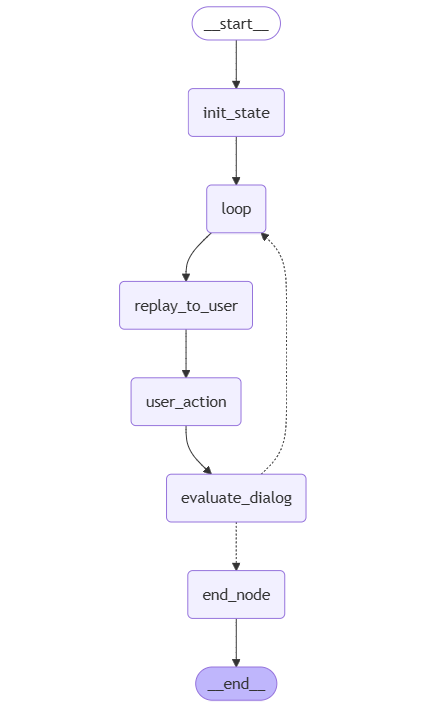